# Aprendizaje por refuerzo profundo - Libreta 6
*por Roberto-Esteban López-Díaz*


Obetivos de esta libreta:
- Métodos de aprendizaje libre de modelo:
- Métodos Monte-Carlo Control
- Métodos SARSA, Q-Learning

In [ ]:
# Ejecutar una vez
!pip install gif
!git clone https://github.com/Bobobert/RL_Toy
!pip install /content/RL_Toy/

In [ ]:
# Importar librerias
import matplotlib.pyplot as plt
import numpy as np
#from RL_Toy.envs import gridWorld
from RL_Toy.policies import gridPolicy, uniformRandomPolicy
from RL_Toy.envs import stochasticGridWorld
from RL_Toy.base import Environment, Policy, Agent, AgentToy
from RL_Toy.utils import Q_function

## Creando un entorno para las pruebas en la libreta

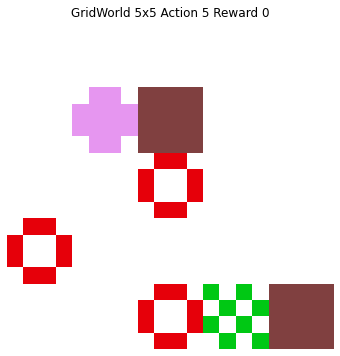

In [ ]:
env = stochasticGridWorld(5,5, (1,1),(4,3),"8C",200)
env.addObstacles((4,4),(1,2))
env.addVortex((4,2,0.5), (2,2,0.2), (3,0,0.6))
obs = env.reset()
env.render()

In [ ]:
pi = gridPolicy(env)

In [ ]:
class AgentGrid(AgentToy):
    def __init__(self, env, policy):
        self.env = env
        self.policy = policy
        super().__init__()
    def processObs(self, obs):
        if isinstance(obs, dict):
            return obs["agent"]
        return obs

In [ ]:
agent = AgentGrid(env, pi)

In [ ]:
agent.test(n_test = 30)

([-18.0,
  -15.0,
  -23.0,
  -17.0,
  -16.0,
  -28.0,
  -17.0,
  -25.0,
  -17.0,
  -19.0,
  -16.0,
  -24.0,
  -17.0,
  -27.0,
  -20.0,
  -26.0,
  -17.0,
  -16.0,
  -15.0,
  -15.0,
  -16.0,
  -18.0,
  -16.0,
  -18.0,
  -17.0,
  -16.0,
  -16.0,
  -24.0,
  -16.0,
  -17.0],
 [4,
  1,
  9,
  3,
  2,
  14,
  3,
  11,
  3,
  5,
  2,
  10,
  3,
  13,
  6,
  12,
  3,
  2,
  1,
  1,
  2,
  4,
  2,
  4,
  3,
  2,
  2,
  10,
  2,
  3])

## Métodos Monte-Carlo

Para esta parte, solo se implementará lo que se vío por GLIE. En el cual de manera **on-policy** se mejora una la política de manera voráz, pero esto asegurandonos que o la política tenga comportamiento exploratorio o cumplir con la suposición de *exploring starts*. 

### Definiendo una politica con comportamiento exploratorio

Se propone elebarorar una nueva polictica que explore, está será de las clases *suaves* o *soft*, en particular $\epsilon - \text{greedy}$. Esto con afán de cumplir las suposiciones que se hace en los algoritmos de aprendizaje sobre una exploración de todos los estados con visitas infinitas. Por practicidad, esta exploración no se lleva al infinito, pero se puede ajustar $\epsilon$ acorde al problemo u observaciones para asegurar de manera empirica la exploración de los estados.

A partir del objeto **gridPolicy**, se expande su comportamiento agregando una epislon.

In [ ]:
class gridPolicyEpsilon(gridPolicy):
    def __init__(self, env: Environment, epsilon: float = 0.1):
        assert (epsilon >= 0) and (epsilon <= 1), "Epsilon needs to be a float in [0,1]"
        super(gridPolicyEpsilon, self).__init__(env)
        self.epsilon = epsilon
        self.greedy = False

    def getAction(self, state):
        throw = np.random.uniform()
        if (throw <= self.epsilon) and (not self.greedy):
            action = self.env.actionSpace.sample()
        else:
            if isinstance(state, dict):
                state = state["agent"]
            action = self.pi[state]
        return action

Se defininen más funciones para el funcionamiento y evaluación  de los algoritmos.

In [ ]:
def test(agent:Agent, n:int = 30):
    results , _ = agent.test(n_test = n)
    print("Return: Mean {}, Std {}".format(np.mean(results), np.std(results)))
    return results

def graphResults(means, stds, testFreq, mod:str, dpi=200):
    mean = np.array(means)
    stds = np.array(stds)
    fig = plt.figure(dpi=dpi)
    plt.title("{}: Mean Return per Episode".format(mod))
    plt.xlabel("Episode")
    plt.ylabel("Mean acumulate Reward")
    x = np.arange(0,len(means)*testFreq, testFreq)
    plt.plot(x, means, label = "Accumulate Reward", lw = 2)
    plt.fill_between(x, means - stds, means + stds, alpha = 0.1)

Probando las nuevas políticas

In [ ]:
pi = gridPolicyEpsilon(env, epsilon = 0.1)
agent = AgentGrid(env, pi)
_ = test(agent)

Return: Mean -29.1, Std 25.585607933628104


In [ ]:
randomAgent = AgentGrid(env, uniformRandomPolicy(env))
results, _ = randomAgent.test(n_test = 100)
_ = test(randomAgent)

Return: Mean -19.366666666666667, Std 6.595368745482612


A continuación se presenta la implementación de GLIE MC, cual acepta una politica $\epsilon - \text{greedy}$ para explorar y mejorar.

In [ ]:
def GLIE_MC(agent:Agent, episodes:int,
            gamma:float = 0.99, freqTest: int = 10**2, epsLife: int = None):
    """
    GLIE MC given an epsilon greedy policy

    parameters
    -----------
    agent: The Agent object which contains the environment
        and the policy
    epsidodes: integer > 0
        Total number of episodes to run the policy and to improve from
    gamma: float
        Discount factor
    freqTest: integer > 0
        The frequency in which a test to evaluate the policy performance is done
    """

    assert (gamma >= 0) and (gamma <= 1), \
        "Gamma discount factor must be in the interval [0,1]"
    assert episodes > 0, \
        "episodes needs to be am integer greater or equal to 1 iteration."

    if epsLife is None:
        epsLife = episodes

    Q = Q_function()
    N = Q_function()
    
    env = agent.env
    policy = agent.policy
    prosObs = agent.processObs
    
    testMean, testStd = [], []
    for episode in range(episodes):
        # Adjust policy's episilon
        policy.epsilon = max(0, 1 - ((episode + 1) / epsLife))

        # Do evaluation if it is time
        if episode % freqTest == 0:
            returns, _ = agent.test(n_test = 30)
            testMean += [np.mean(returns)]
            testStd += [np.std(returns)]

        # Sample a whole episode
        obs = env.reset()
        done, states, actions, rewards, returns = False, [], [], [], []
        while not done:
            state = prosObs(obs)
            action = policy.getAction(state)
            # Save the states and action seen
            states += [state]
            actions += [action]
            # Add 1 to the counter for the pair
            N[(state, action)] = N[(state, action)] + 1
            # Do the step on the environment
            obs, reward, done = env.step(action)
            rewards += [reward]
            returns += [0.0]

        # After done, calculate the returns
        returns[-1] = rewards[-1]
        for i in range(len(rewards) - 2, -1, -1): # i goes from the top to bottom of the lists
            returns[i] = rewards[i] + gamma * returns[i + 1]

        # Update the value function
        for i in range(len(states)):
            state_action = (states[i], actions[i])
            actualQ = Q[state_action]
            actualN =  1 / N[state_action]
            Q[state_action] = actualQ + actualN * (returns[i] - actualQ)

        # Update the policy in a greedy manner
        for state in Q.getStates():
            maxAction = Q.maxAction(state)
            agent.update(state, maxAction)

    graphResults(testMean, testStd, freqTest, "GLIE")
    return Q, N

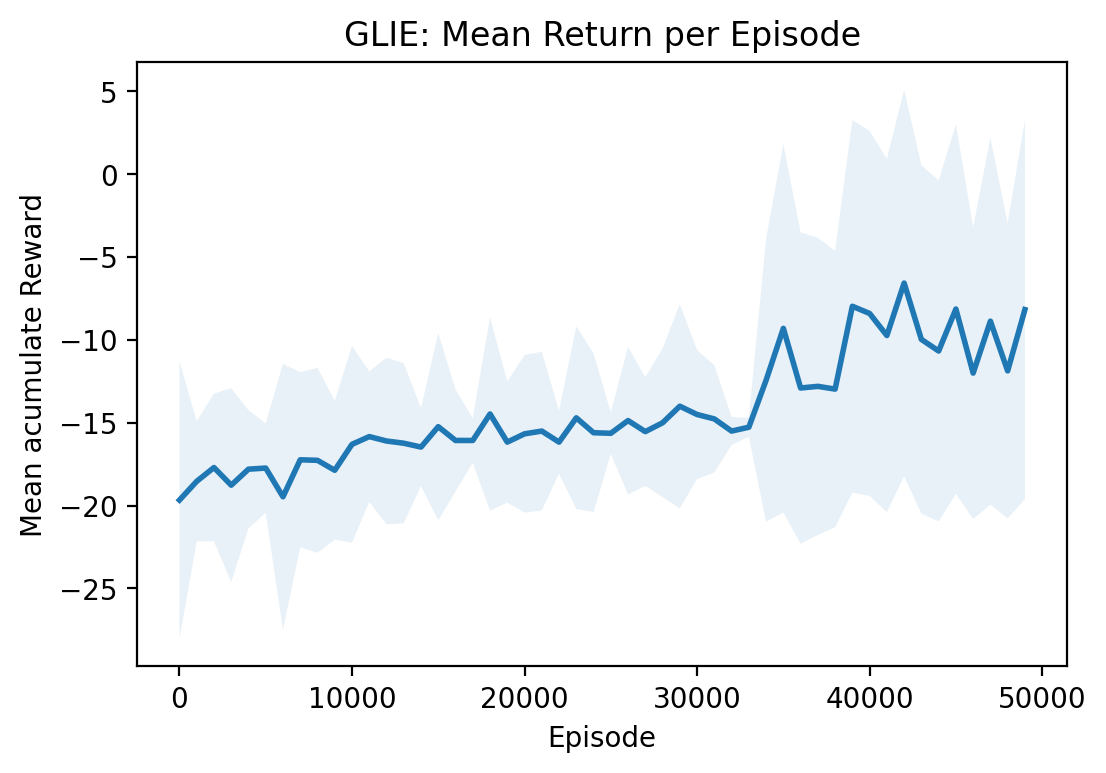

In [ ]:
Q, N = GLIE_MC(agent, 5*10**4, 0.99, freqTest=10**3)

In [ ]:
print(N.states)

{(1, 1): {5: 3882, 4: 3875, 6: 3839, 1: 3755, 9: 18134, 2: 3776, 3: 3855, 7: 3837, 8: 18726}, (1, 0): {2: 684, 7: 700, 6: 704, 1: 700, 3: 680, 9: 2197, 5: 686, 4: 639, 8: 1053}, (0, 0): {7: 783, 4: 801, 6: 820, 3: 785, 2: 821, 9: 2791, 5: 804, 1: 795, 8: 822}, (0, 1): {4: 774, 1: 820, 2: 772, 6: 849, 9: 861, 7: 809, 5: 772, 3: 796, 8: 2756}, (0, 2): {2: 663, 1: 666, 3: 658, 7: 688, 8: 710, 5: 655, 6: 668, 9: 2421, 4: 665}, (2, 1): {4: 659, 1: 685, 8: 691, 5: 620, 7: 731, 3: 662, 9: 13020, 2: 697, 6: 733}, (3, 1): {7: 61, 9: 72, 3: 70, 1: 44, 6: 337, 2: 41, 8: 51, 5: 62, 4: 50}, (0, 3): {3: 237, 6: 194, 4: 201, 9: 218, 7: 232, 2: 212, 1: 235, 5: 214, 8: 544}, (0, 4): {1: 138, 5: 131, 6: 126, 7: 296, 4: 143, 3: 137, 2: 126, 8: 123, 9: 126}, (1, 3): {7: 469, 5: 341, 8: 316, 2: 286, 9: 1404, 3: 315, 1: 356, 4: 315, 6: 307}, (2, 0): {1: 440, 3: 396, 6: 1220, 5: 425, 9: 434, 7: 404, 8: 1034, 4: 415, 2: 433}, (2, 3): {9: 413, 8: 93, 7: 92, 1: 106, 4: 117, 5: 99, 6: 111, 2: 100, 3: 103}, (3, 4

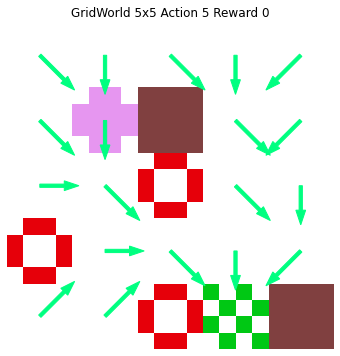

In [ ]:
agent.testMode(False)
env.reset()
env.render(policy = agent.policy)

## Métodos de Diferencias Temporales (TD)

A continuación, se desarrollan los algoritmos de control basados en aprendizaje por diferencias temporales.

### SARSA

Comenzando por SARSA, se implementa el siguiente

In [ ]:
def SARSA(agent: Agent, episodes:int,
          gamma:float = 0.99, alpha: float = 0.01, freqTest: int = 10**2, epsLife:int = None):
    """
    SARSA algorithm

    parameters
    -----------
    agent: The Agent object which contains the environment
        and the policy
    epsidodes: integer > 0
        Total number of episodes to run the policy and to improve from
    gamma: float
        Discount factor
    alpha: float > 0
        Learning step
    freqTest: integer > 0
        The frequency in which a test to evaluate the policy performance is done
    """
    assert (alpha > 0), \
        "alpha learn step must be in the interval [0,1]"
    assert (gamma >= 0) and (gamma <= 1), \
        "Gamma discount factor must be in the interval [0,1]"
    assert episodes > 0, \
        "episodes needs to be am integer greater or equal to 1 iteration."

    if epsLife is None:
        epsLife = episodes

    Q = Q_function()
    
    env = agent.env
    policy = agent.policy
    prosObs = agent.processObs

    testMean, testStd = [], []
    for episode in range(episodes):
        # Adjust epsilon
        agent.policy.epsilon = max(0, 1 - ((episode + 1) / epsLife))

        # Do evaluation if it is time
        if episode % freqTest == 0:
            returns, _ = agent.test(n_test = 30)
            testMean += [np.mean(returns)]
            testStd += [np.std(returns)]

        # Sample a whole episode
        obs = env.reset()
        state = prosObs(obs)
        done = False
        while not done:
            action = agent.getAction(state)
            # Do the step on the environment
            obs, reward, done = env.step(action)
            # chose action for next state
            state2 = prosObs(obs)
            action_2 = agent.getAction(state2)
            # Calculate the update
            td_target = reward + gamma * Q[(state2, action_2)]
            actualQ = Q[(state, action)]
            Q[(state, action)] = actualQ + alpha * (td_target - actualQ)

            # Update policy greedy
            agent.update(state, Q.maxAction(state))

            # interchange
            state, action = state2, action_2

    graphResults(testMean, testStd, freqTest, "SARSA")
    return Q

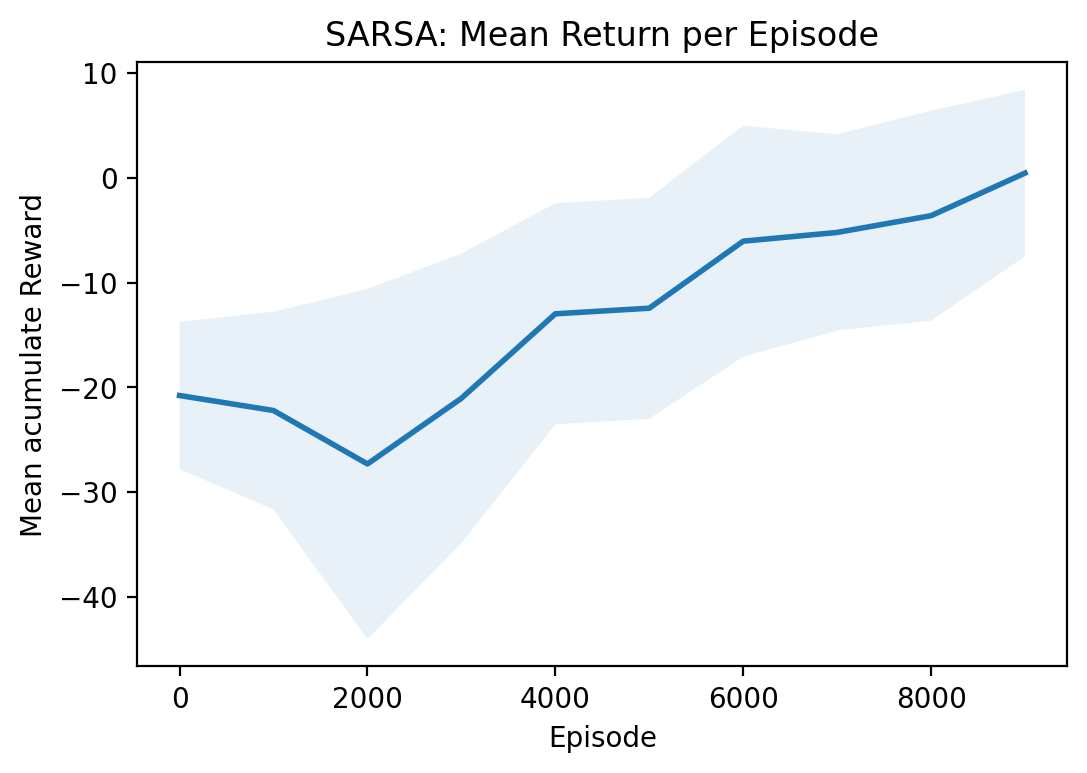

In [ ]:
agentSarsa = AgentGrid(env, 
                       gridPolicyEpsilon(env, epsilon = 0.2))
Q_sarsa = SARSA(agentSarsa, episodes = 10**4,
                    gamma = 0.99, alpha=0.01, freqTest= 10**3)

### Q-Learning

Ahora es el turno del Q learning

In [ ]:
def Q_learning(agent:Agent, explorationPolicy:Policy, episodes:int,
          gamma:float = 0.99, alpha: float = 0.01, freqTest: int = 10**2):
    """
    Q_learning algorithm

    parameters
    -----------
    agent: The Agent object which contains the environment
        and the policy
    explorationPolicy: Policy type object
        An epsilon-greedy type of policy
    epsidodes: integer > 0
        Total number of episodes to run the policy and to improve from
    gamma: float
        Discount factor
    alpha: float > 0
        Learning step
    freqTest: integer > 0
        The frequency in which a test to evaluate the policy performance is done
    """
    assert (alpha > 0), "alpha learn step must be in the interval [0,1]"
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert episodes > 0, "episodes needs to be am integer greater or equal to 1 iteration."

    Q = Q_function()
    prosObs = agent.processObs

    testMean, testStd = [], []
    for episode in range(episodes):

        # Do evaluation if it is time
        if episode % freqTest == 0:
            returns, _ = agent.test(n_test = 30)
            testMean += [np.mean(returns)]
            testStd += [np.std(returns)]

        # Sample a whole episode
        obs = env.reset()
        state = prosObs(obs)
        done = False
        while not done:
            ### MISSING CODE
            ## Q-Learning missing
            
            # interchange
            obs = obs_2

    graphResults(testMean, testStd, freqTest, "Q-Learning")
    return Q

In [ ]:
agentQ = AgentGrid(env, 
                       gridPolicy(env))
pi_epsilon = gridPolicyEpsilon(env, epsilon=0.8)
Q_q = Q_learning(agentQ, pi_epsilon, episodes = 5*10**4, gamma = 0.99,
                 alpha=0.01, freqTest= 10**3)